In [2]:
import pandas as pd
pd.options.display.max_columns = None
import os
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

In [3]:
import matplotlib.pyplot as plt

In [4]:
#提取base_feature
def get_base_feature(df):
    df['time'] = df.START_DATE.apply(lambda x:x[:19])
    df['time'] = pd.to_datetime(df['time'],format='%Y-%m-%d-%H.%M.%S')
    timedelta = df['time'] - pd.datetime(df['time'].dt.year[0],df['time'].dt.month[0],df['time'].dt.day[0],0,0,0)
    df['30_min'] = timedelta.dt.seconds/1800
    df['30_min'] = df['30_min'].astype(int)
    df['20_min'] = timedelta.dt.seconds/1200
    df['20_min'] = df['20_min'].astype(int)
    df['10_min'] = timedelta.dt.seconds/600
    df['10_min'] = df['10_min'].astype(int)
    df['5_min'] = timedelta.dt.seconds/300
    df['5_min'] = df['5_min'].astype(int)
#     df['3_min'] = timedelta.dt.seconds/300
#     df['3_min'] = df['3_min'].astype(int)

    df['hour'] = df.START_DATE.apply(lambda x:int(x[11:13]))
    
    
    df.TRADE_TYPE[df.TRADE_TYPE==21] = 1
    df.TRADE_TYPE[df.TRADE_TYPE==22] = 0
    
    result = df.groupby(['date','TRADE_ADDRESS','INDUSTRY_CODE','CARD_TYPE_EX','CARD_TYPE','SAM_ID','TERMINAL_ID','RECORD_ROW','30_min','20_min','10_min','5_min']).TRADE_TYPE.agg(['count','sum']).reset_index()
    result['inNums'] = result['sum']
    result['outNums'] = result['count'] - result['sum']
    del result['count'],result['sum']
    
    result.date = pd.to_datetime(result.date)
    result['week'] = result.date.dt.dayofweek+1
    del df
    return result

In [5]:
#进一步提取特征
def more_feature(result):
    tmp = result.copy()

    tmp = result.groupby(['TRADE_ADDRESS'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_w_max'    : 'max',
                                                                        'inNums_ID_w_min'    : 'min', 
                                                                        'inNums_ID_w_mean'   : 'mean',
                                                                        'inNums_ID_w_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['TRADE_ADDRESS'], how='left')

    tmp = result.groupby(['TRADE_ADDRESS','week','30_min'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_w_h_3_max'    : 'max',
                                                                        'inNums_ID_w_h_3_min'    : 'min', 
                                                                        'inNums_ID_w_h_3_mean'   : 'mean',
                                                                        'inNums_ID_w_h_3_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp,on=['TRADE_ADDRESS','week','30_min'],how = 'left')

    tmp = result.groupby(['TRADE_ADDRESS','20_min'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_w_h_2_max'    : 'max',
                                                                        'inNums_ID_w_h_2_min'    : 'min', 
                                                                        'inNums_ID_w_h_2_mean'   : 'mean',
                                                                        'inNums_ID_w_h_2_sum'   : 'sum',      
                                                                
                                                                        })
    result = result.merge(tmp,on=['TRADE_ADDRESS','20_min'],how = 'left')
    
    tmp = result.groupby(['TRADE_ADDRESS','5_min'], as_index=False)['inNums'].agg({
                                                                        'inNums_ID_w_h_5_max'    : 'max',
                                                                        'inNums_ID_w_h_5_min'    : 'min', 
                                                                        'inNums_ID_w_h_5_mean'    : 'mean',
                                                                        'inNums_ID_w_h_5_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp,on=['TRADE_ADDRESS','5_min'],how = 'left')
    
    
    
    ###出站与进站类似

    
    
    tmp = result.groupby(['TRADE_ADDRESS'], as_index=False)['outNums'].agg({
                                                                        'outNums_ID_max'    : 'max',
                                                                        'outNums_ID_min'    : 'min',
                                                                        'outNums_ID_mean'   : 'mean',
                                                                        'outNums_ID_sum'   : 'sum'
                                                                        })
    result = result.merge(tmp, on=['TRADE_ADDRESS'], how='left')
    



    tmp = result.groupby(['TRADE_ADDRESS','30_min'], as_index=False)['outNums'].agg({
                                                                       
                                                                        'outNums_ID_w_h_3_max'    : 'max', 
                                                                        'outNums_ID_w_h_3_min'    : 'min', 
                                                                        'outNums_ID_w_h_3_mean'    : 'mean',
                                                                        'outNums_ID_w_h_3_sum'    : 'sum', 
                                                           
                                                                        })
    result = result.merge(tmp,on=['TRADE_ADDRESS','30_min'],how = 'left')

    tmp = result.groupby(['TRADE_ADDRESS','20_min'], as_index=False)['outNums'].agg({
                                                              
                                                                        'outNums_ID_w_h_2_max'    : 'max', 
                                                                        'outNums_ID_w_h_2_min'    : 'min', 
                                                                        'outNums_ID_w_h_2_mean'    : 'mean', 
                                                                        'outNums_ID_w_h_2_sum'    : 'sum', 
                                                    
                                         
                                                                        })
    result = result.merge(tmp,on=['TRADE_ADDRESS','20_min'],how = 'left')

    tmp = result.groupby(['TRADE_ADDRESS','5_min'], as_index=False)['outNums'].agg({
                                                  
                                                                        'outNums_ID_w_h_5_max'   : 'max',
                                                                        'outNums_ID_w_h_5_min'   : 'min',
                                                                        'outNums_ID_w_h_5_mean'   : 'mean',
                                                                        'outNums_ID_w_h_5_sum'   : 'sum',
                                               
                                                                        })
    result = result.merge(tmp,on=['TRADE_ADDRESS','5_min'],how = 'left')
    
    return result

In [6]:
path = '../dataofweek/'

In [7]:
data12 = pd.read_csv(path+'12_week.csv')

In [8]:
data15 = pd.read_csv(path+'15_week.csv')

In [9]:
data16 = pd.read_csv(path+'16_week.csv')

In [10]:
df125 = data12[data12.week==7]
df155 = data15[data15.week==7]
df165 = data16[data16.week==7]

In [11]:
del data15,data16,data12

In [12]:
data = pd.concat([df125,df155],axis=0,ignore_index=True)
data = pd.concat([data,df165],axis=0,ignore_index=True)

In [13]:
le = LabelEncoder()

In [14]:
data.SAM_ID = le.fit_transform(data.SAM_ID.values)

In [15]:
data.TERMINAL_ID = le.fit_transform(data.TERMINAL_ID.values)

In [16]:
data = get_base_feature(data)

In [17]:
data = more_feature(data)

In [18]:
data.shape

(1624405, 47)

In [19]:
prevent = data.copy()

In [20]:
#删除类别列别超过90%的列
cols = list(data.columns)
for col in cols:
    rate = data[col].value_counts(normalize = True,dropna = False).values[0]
    if (rate>0.9):
        cols.remove(col)
        print(col,rate)
data = data[cols]

INDUSTRY_CODE 0.9643968099088589
week 1.0
inNums_ID_w_min 1.0
inNums_ID_w_h_3_min 0.9999525980282011
inNums_ID_w_h_2_max 0.9063478627559014
inNums_ID_w_h_5_min 0.9991042874160077
outNums_ID_min 1.0
outNums_ID_w_h_3_min 0.9998848809256312
outNums_ID_w_h_2_min 0.9998867277557013


In [21]:
columns = [ 'date',
    'TRADE_ADDRESS',
 'CARD_TYPE_EX',
 'CARD_TYPE',
 'SAM_ID',
 'TERMINAL_ID',
 'RECORD_ROW',
 '30_min',
 '20_min',
 '10_min',
 '5_min',
 'inNums',
 'outNums',
 'inNums_ID_w_mean',
 'inNums_ID_w_sum',

 'inNums_ID_w_h_3_mean',
 'inNums_ID_w_h_3_sum',

 'inNums_ID_w_h_2_mean',
 'inNums_ID_w_h_2_sum',
 'inNums_ID_w_h_5_max',
 'inNums_ID_w_h_5_mean',
 'inNums_ID_w_h_5_sum',
 'outNums_ID_max',
 'outNums_ID_mean',
 'outNums_ID_sum',
 'outNums_ID_w_h_3_mean',
 'outNums_ID_w_h_3_sum',
 'outNums_ID_w_h_2_max',
 'outNums_ID_w_h_2_mean',
 'outNums_ID_w_h_2_sum',
 'outNums_ID_w_h_5_max',
 'outNums_ID_w_h_5_min',
 'outNums_ID_w_h_5_mean',
 'outNums_ID_w_h_5_sum']

In [22]:
data = data[columns]

In [23]:
data.date.unique()

array(['2015-10-25T00:00:00.000000000', '2015-11-15T00:00:00.000000000',
       '2015-11-22T00:00:00.000000000'], dtype='datetime64[ns]')

In [24]:
sub = data[data.date=='2015-11-22']

In [25]:
#lgb参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    'reg_alpha':1,
    'reg_lambda':2,
    'min_child_weight':6
}

In [91]:
train_in = data[data.date=='2015-11-15']
y_train = train_in['inNums']
del train_in['inNums'],train_in['outNums']
del train_in['date']

val_in = data[data.date=='2015-10-25']
y_val = val_in['inNums']
del val_in['inNums'],val_in['outNums']
del val_in['date']


test_in = data[data.date=='2015-11-22']
y_test = test_in['inNums']
del test_in['inNums'],test_in['outNums']
del test_in['date']

lgb_train = lgb.Dataset(train_in, y_train)
lgb_evals = lgb.Dataset(val_in, y_val , reference=lgb_train)

In [92]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=50,
                verbose_eval=1000,
                )

Training until validation scores don't improve for 50 rounds.
[1000]	train's l1: 0.023985	valid's l1: 0.22914
[2000]	train's l1: 0.0149217	valid's l1: 0.211582
[3000]	train's l1: 0.0111732	valid's l1: 0.205233
[4000]	train's l1: 0.00918069	valid's l1: 0.202262
[5000]	train's l1: 0.00791346	valid's l1: 0.200506
[6000]	train's l1: 0.00715271	valid's l1: 0.199452
[7000]	train's l1: 0.00656286	valid's l1: 0.198618
[8000]	train's l1: 0.00613388	valid's l1: 0.197987
[9000]	train's l1: 0.00580398	valid's l1: 0.197504
[10000]	train's l1: 0.00553794	valid's l1: 0.197119
[11000]	train's l1: 0.00531959	valid's l1: 0.19679
[12000]	train's l1: 0.00513842	valid's l1: 0.196533
[13000]	train's l1: 0.0049806	valid's l1: 0.196308
[14000]	train's l1: 0.00484944	valid's l1: 0.196116
[15000]	train's l1: 0.00473338	valid's l1: 0.195948
[16000]	train's l1: 0.00462766	valid's l1: 0.195796
[17000]	train's l1: 0.00453357	valid's l1: 0.195656
[18000]	train's l1: 0.00444737	valid's l1: 0.195526
[19000]	train's l1

In [93]:
pre_in = gbm.predict(test_in,num_iteration=gbm.best_iteration)

In [94]:
error_in = mean_absolute_error(pre_in,y_test)
error_in

0.010531489887573428

In [95]:
sub['pre_in'] = pre_in

In [96]:
train_out = data[data.date=='2015-11-15']
y_train = train_out['outNums']
del train_out['inNums'],train_out['outNums']
del train_out['date']

val_out = data[data.date=='2015-10-25']
y_val = val_out['outNums']
del val_out['inNums'],val_out['outNums']
del val_out['date']

test_out = data[data.date=='2015-11-22']
y_test = test_out['outNums']
del test_out['inNums'],test_out['outNums']
del test_out['date']

lgb_train = lgb.Dataset(train_out, y_train)
lgb_evals = lgb.Dataset(val_out, y_val , reference=lgb_train)

In [97]:
gbm1 = lgb.train(params,
                lgb_train,
                num_boost_round=16000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=50,
                verbose_eval=1000,
                )

Training until validation scores don't improve for 50 rounds.
[1000]	train's l1: 0.0257612	valid's l1: 0.229761
[2000]	train's l1: 0.016785	valid's l1: 0.212066
[3000]	train's l1: 0.0135326	valid's l1: 0.206615
[4000]	train's l1: 0.0118947	valid's l1: 0.204082
[5000]	train's l1: 0.0108511	valid's l1: 0.202524
[6000]	train's l1: 0.0101931	valid's l1: 0.201534
[7000]	train's l1: 0.00975573	valid's l1: 0.200844
[8000]	train's l1: 0.00943702	valid's l1: 0.200361
[9000]	train's l1: 0.00917792	valid's l1: 0.199978
[10000]	train's l1: 0.00896681	valid's l1: 0.199644
[11000]	train's l1: 0.00880073	valid's l1: 0.199369
[12000]	train's l1: 0.00866028	valid's l1: 0.199158
[13000]	train's l1: 0.00854114	valid's l1: 0.198953
[14000]	train's l1: 0.00845307	valid's l1: 0.1988
[15000]	train's l1: 0.00837367	valid's l1: 0.198666
[16000]	train's l1: 0.00830492	valid's l1: 0.198556
Did not meet early stopping. Best iteration is:
[16000]	train's l1: 0.00830492	valid's l1: 0.198556


In [98]:
pre_out = gbm1.predict(test_out,num_iteration=gbm1.best_iteration)

In [99]:
mean_absolute_error(pre_out,y_test)

0.014349878950115235

In [100]:
sub['pre_out'] = pre_out

In [101]:
sub1 = sub.groupby(['date','TRADE_ADDRESS']).pre_in.agg({'inNums':'sum'}).reset_index()
sub2 = sub.groupby(['date','TRADE_ADDRESS']).pre_out.agg({'outNums':'sum'}).reset_index()
sub_result = sub1.merge(sub2,on = ['date','TRADE_ADDRESS'],how='left')
sub_result['flow'] = sub_result.inNums + sub_result.outNums
sub_result['round_pre'] = np.round(sub_result.flow)
sub_result['round_in'] = np.round(sub_result.inNums)
sub_result['round_out'] = np.round(sub_result.outNums)

In [102]:
real1 = sub.groupby(['date','TRADE_ADDRESS']).inNums.agg({'inNums':'sum'}).reset_index()
real2 = sub.groupby(['date','TRADE_ADDRESS']).outNums.agg({'outNums':'sum'}).reset_index()
real = real1.merge(real2,on = ['date','TRADE_ADDRESS'],how='left')
real['flow'] = real.inNums + real.outNums

In [103]:
error=mean_absolute_error(sub_result.round_pre,real.flow)

In [104]:
error

22.8

In [105]:
sub_result.head()

,date,TRADE_ADDRESS,inNums,outNums,flow,round_pre,round_in,round_out
0,2015-11-22,121,18323.905180,15234.586742,33558.491923,33558.0,18324.0,15235.0
1,2015-11-22,123,6176.939200,6286.809071,12463.748271,12464.0,6177.0,6287.0
2,2015-11-22,125,10298.072131,12343.584138,22641.656269,22642.0,10298.0,12344.0
3,2015-11-22,127,11730.694351,11111.857792,22842.552142,22843.0,11731.0,11112.0
4,2015-11-22,129,6879.453685,6965.237030,13844.690716,13845.0,6879.0,6965.0


In [106]:
real.head()

,date,TRADE_ADDRESS,inNums,outNums,flow
0,2015-11-22,121,18359,15220,33579
1,2015-11-22,123,6204,6255,12459
2,2015-11-22,125,10725,11799,22524
3,2015-11-22,127,11771,11055,22826
4,2015-11-22,129,6990,6848,13838


In [42]:
re_path = '../result1/'
sub_result.to_csv(re_path+'7_flow_pre_'+str('%.2f'%error)+'.csv',encoding='utf-8',index=False)
real.to_csv(re_path+'7_flow_real.csv',encoding='utf-8',index=False)

In [43]:
features=train_in.columns
feature_rank=gbm.feature_importance()
features_df=pd.DataFrame({ 'column':features,'importance': feature_rank}).sort_values(by='importance', ascending=False)
print(features_df)

                   column  importance
4             TERMINAL_ID      149556
3                  SAM_ID      123408
5              RECORD_ROW      103737
17   inNums_ID_w_h_5_mean      101341
29  outNums_ID_w_h_5_mean       43083
18    inNums_ID_w_h_5_sum       42659
12   inNums_ID_w_h_3_mean       26258
14   inNums_ID_w_h_2_mean       21076
15    inNums_ID_w_h_2_sum       19313
30   outNums_ID_w_h_5_sum       18505
13    inNums_ID_w_h_3_sum       18336
8                  10_min       12674
0           TRADE_ADDRESS       12611
6                  30_min       12542
9                   5_min       11930
26   outNums_ID_w_h_2_sum       10520
22  outNums_ID_w_h_3_mean       10455
7                  20_min       10123
23   outNums_ID_w_h_3_sum        9539
11        inNums_ID_w_sum        8068
10       inNums_ID_w_mean        7810
1            CARD_TYPE_EX        7770
25  outNums_ID_w_h_2_mean        7044
2               CARD_TYPE        6096
21         outNums_ID_sum        3231
20        ou

In [44]:
date_list = list(data.date.unique())

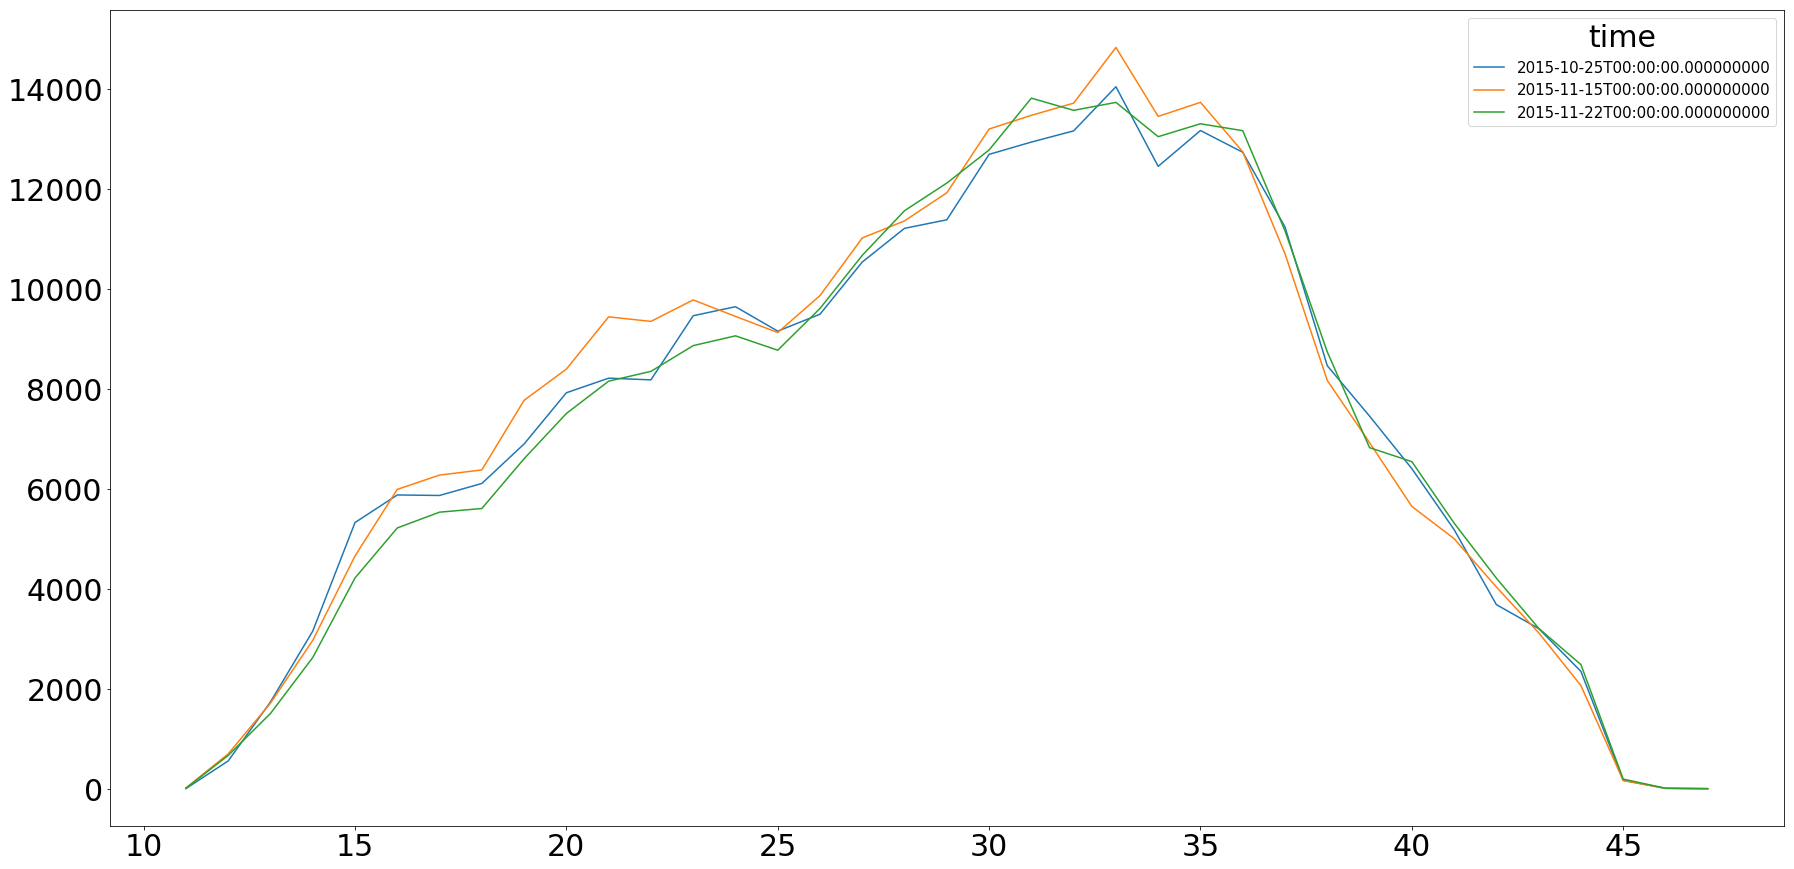

In [45]:
fig = plt.figure(figsize=(30,15))
for i in date_list:
    hh = data[data.date==i]
    hhh = hh.groupby(['30_min']).inNums.agg({'inNums':'sum'}).reset_index()
    plt.plot(hhh['30_min'],hhh['inNums'],label = i)
    
legend=plt.legend(title='time', fontsize=15)
legend.get_title().set_fontsize(fontsize=30)

plt.tick_params(labelsize=30)
plt.show()